In [1]:
%pylab inline
import pandas as pd
import time
import numpy as np
import psycopg2
import gzip
#from sklearn import *
import os
import csv
from pandas import *
import datetime as dt
from datetime import date, datetime, timedelta
from collections import Counter
plt.style.use('ggplot') 
pandas.set_option('display.max_columns', None)

Populating the interactive namespace from numpy and matplotlib


### Load data, clean up tables:
-----------------------------------------

In [ ]:
## Load data:

#%run generateTables-tmp.py
%run generateTables.py

In [ ]:
# create a database connection
sqluser = 'bee_mimic_admin'
dbname = 'bee_mimic'
schema_name = 'mimiciii'
sqlpwd = "2OKF0dr@czOrD0suS4GyN"

# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser, password=sqlpwd)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)
vent_id = 225792

query = """
SELECT ad.subject_id as subject
  , ad.hadm_id as hadm
  , ch.itemid
  , di.label
  , di.unitname as unit
  , ch.charttime
  , ch.valuenum as value
  , ad.hospital_expire_flag as h_exp
FROM admissions ad
INNER JOIN procedureevents_mv pr
ON ad.subject_id = pr.subject_id
INNER JOIN chartevents ch 
ON ad.hadm_id = ch.hadm_id
INNER join d_items di
ON ch.itemid = di.itemid
WHERE pr.itemid = """ + str(vent_id) + """ AND pr.hadm_id = ad.hadm_id 
AND ch.itemid in (220210,3337,224422,618,3603,615,619,224688,224689,
211,220045,
780,223830,1126,4753,3839,
223835,3420,2981,727,3422,227009,
646,220277,
220339,505,506,224700,686,
224684,683,224685,682,224686,684,224421,654,3050,2566,681,3083,2311,
223849,720,
220179,455,
220180,8441,
220181,456,
1394,226707, 226730,
763,224639,3580,3583,226512,581,580,
676,223762,
224687,448,450,445,
470,471,223834,227287,194,224691,
224697,444,
224695,535,
224696,543,
220224,3785,3837,
220235,3784,3835,
220227,834,
30056,226452,225797,
30058,30065,225944,
40055,43175,40069,40094,40715,40473,40085,40057,40056,40405,40428,40096,40,651,226560,227510,226561,227489,226584,226563,226564,226565,226557,226558,226559,
224715, 224716, 224717, 224833,
228444,
228096,
198,227013,226755,
1090,
225059,225811,
225624,220615,225170,227428,220545,226996,
227054, 227000, 227005, 227017)
ORDER BY ad.subject_id, ch.charttime
"""
vitals = pd.read_sql_query(query,con)

In [24]:
ventilation.head()

,subject,hadm,admittype,subj_ethnicity,gender,dateofbirth,diagnosis,admit_time,discharge_time,death_time,vent_starttime,vent_endtime,h_exp,exp
0,36,165660,ELECTIVE,WHITE,M,2061-08-17,VENTRAL HERNIA/SDA,2134-05-10 11:30:00,2134-05-20 13:16:00,NaT,2134-05-12 16:00:00,2134-05-16 15:14:00,0,0
1,107,174162,EMERGENCY,HISPANIC OR LATINO,M,2052-04-02,UPPER GI BLEED,2122-05-14 19:37:00,2122-05-18 15:11:00,NaT,2122-05-15 14:27:00,2122-05-15 15:33:00,0,0
2,111,155897,EMERGENCY,WHITE,F,2075-07-16,PNEUMONIA,2144-07-01 04:12:00,2144-07-01 14:55:00,2144-07-01 14:55:00,2144-07-01 11:16:00,2144-07-01 17:56:00,1,1
3,124,138376,EMERGENCY,WHITE,M,2090-11-19,PNEUMONIA;CHRONIC OBST PULM DISEASE,2165-12-31 18:55:00,2166-02-01 06:55:00,2166-02-01 06:55:00,2166-01-13 00:12:00,2166-02-01 10:52:00,1,1
4,188,123860,EMERGENCY,WHITE,M,2105-05-18,HEPATIC ENCEPHALOPATHY,2160-12-31 12:34:00,2161-01-08 19:50:00,NaT,2160-12-31 13:32:00,2161-01-02 10:33:00,0,1


In [25]:
notes.head()

,subject,hadm,note_date,category,description,cgid,iserror,text
0,36,165660,2134-05-11,ECG,Report,NaN,None,Sinus rhythm. Normal tracing. Since the previo...
1,36,165660,2134-05-20,ECG,Report,NaN,None,Sinus rhythm. Normal tracing. Since the previo...
2,36,165660,2134-05-12,Echo,Report,NaN,None,PATIENT/TEST INFORMATION:\nIndication: Coronar...
3,36,165660,2134-05-20,Discharge summary,Report,NaN,None,Admission Date: [**2134-5-10**] ...
4,107,174162,2122-05-14,ECG,Report,NaN,None,Sinus rhythm. Left atrial abnormality with a c...


In [87]:
inputevents_mv[inputevents_mv.label.str.contains("Midazolam|Propofol|Dexmedetomidine|Hydromorphone|Morphine|Fentanyl|Lorazepam") & (inputevents_mv.ordercat == "Continuous Med")].label.value_counts()

Propofol                      154591
Fentanyl (Concentrate)         45512
Midazolam (Versed)             39854
Fentanyl                       16801
Dexmedetomidine (Precedex)     14759
Morphine Sulfate                3498
Hydromorphone (Dilaudid)         737
Lorazepam (Ativan)               214
Name: label, dtype: int64

In [89]:
inputevents_mv[(inputevents_mv.label == "Lorazepam (Ativan)")& (inputevents_mv.ordercat == "Continuous Med")]
#inputevents_mv[inputevents_mv[inputevents_mv.rate >1000.0]]
#hist(np.round(inputevents_mv[inputevents_mv.label == "Propofol"].rate).value_counts(), 1000)

,subject,hadm,input_start,input_end,item,label,amount,amountuom,rate,rateuom,ordercat,ptweight,totalamount,totalamountuom,status
60031,5382,172484,2191-01-31 15:57:00,2191-02-01 11:00:00,221385,Lorazepam (Ativan),19.050000,mg,1.000000,mg/hour,Continuous Med,65.8,60.0,ml,Changed
60048,5382,172484,2191-02-01 11:00:00,2191-02-01 14:35:00,221385,Lorazepam (Ativan),1.791667,mg,0.500000,mg/hour,Continuous Med,65.8,60.0,ml,Changed
60053,5382,172484,2191-02-01 14:35:00,2191-02-01 15:00:00,221385,Lorazepam (Ativan),0.416755,mg,1.000213,mg/hour,Continuous Med,65.8,60.0,ml,Changed
60060,5382,172484,2191-02-01 15:00:00,2191-02-01 16:20:00,221385,Lorazepam (Ativan),2.667234,mg,2.000426,mg/hour,Continuous Med,65.8,60.0,ml,Changed
60065,5382,172484,2191-02-01 16:20:00,2191-02-01 19:30:00,221385,Lorazepam (Ativan),9.506415,mg,3.002026,mg/hour,Continuous Med,65.8,60.0,ml,Changed
60070,5382,172484,2191-02-01 19:30:00,2191-02-02 02:08:00,221385,Lorazepam (Ativan),26.567930,mg,4.005216,mg/hour,Continuous Med,65.8,60.0,ml,Rewritten
60072,5382,172484,2191-02-01 19:30:00,2191-02-01 19:31:00,221385,Lorazepam (Ativan),0.066754,mg,4.005216,mg/hour,Continuous Med,65.8,60.0,ml,Rewritten
60073,5382,172484,2191-02-01 19:30:00,2191-02-02 02:03:00,221385,Lorazepam (Ativan),26.168000,mg,3.995115,mg/hour,Continuous Med,65.8,60.0,ml,FinishedRunning
60082,5382,172484,2191-02-02 02:03:00,2191-02-02 17:02:00,221385,Lorazepam (Ativan),60.011487,mg,4.005216,mg/hour,Continuous Med,65.8,60.0,ml,Rewritten
60083,5382,172484,2191-02-02 02:03:00,2191-02-02 16:59:00,221385,Lorazepam (Ativan),59.800000,mg,4.004464,mg/hour,Continuous Med,65.8,60.0,ml,FinishedRunning


In [90]:
inputevents_mv.label.value_counts().head(5)

NaCl 0.9%            416608
Dextrose 5%          322196
Solution             231670
Propofol             173247
Insulin - Regular    102015
Name: label, dtype: int64

In [118]:
notes[notes.text.str.contains("lobect")].head(50)
#notes[(notes.subject == 266) & (notes.text.str.contains("asthma|Asthma"))].text[336]
#notes[notes.text.str.contains("asthma|Asthma")].text[289]

"Admission Date:  [**2134-5-10**]              Discharge Date:   [**2134-5-20**]\n\nDate of Birth:  [**2061-8-17**]             Sex:   M\n\nService: PLASTIC\n\nAllergies:\nPatient recorded as having No Known Allergies to Drugs\n\nAttending:[**First Name3 (LF) 1430**]\nChief Complaint:\nRecurrent ventral herniation with omentum up in the anterior\nchest\n\nMajor Surgical or Invasive Procedure:\nVentral hernia repair, placement of SurgiMend and omentectomy.\nSternal plate removal.\n\n\nHistory of Present Illness:\nMr. [**Known lastname 27218**] is a 72 y.o. male with PMH significant for CAD s/p\nCABG ([**2131-5-4**]), COPD, HTN who presents with recurrent ventral\nhernia.\n\nApproximately three years ago ([**2131-5-18**]), the patient had a\nsternal repair done with plates. He had an omental transfer and\nat that time a ventral hernia repair to the anterior fascia at\nthe bottom of sternotomy lead to a hernia. This was actually\nrepaired primarily and reinforced with mesh. A separate new

In [ ]:
vitals = vitals.drop_duplicates()
vitals = vitals.loc[vitals['value'].notnull()]
vitals.to_pickle("vitals2.pkl")

In [4]:
## De-duplicate tables:

ventilation = ventilation.drop_duplicates()
sedation = sedation.drop_duplicates()
vitals = vitals.drop_duplicates()
inputevents_mv = inputevents_mv.drop_duplicates()
notes = notes.drop_duplicates()
## Filter by admission length (2days to 30days): let's do this later.

# --> Yields 10722 rows, 8860 unique hadms. Filter vitals, sedation tables by these hadms:

uniq_hadms = ventilation.hadm.unique()
vitals = vitals.loc[vitals.hadm.isin(uniq_hadms)]
sedation = sedation.loc[sedation.hadm.isin(uniq_hadms)]
inputevents_mv = inputevents_mv.loc[inputevents_mv.hadm.isin(uniq_hadms)]
notes = notes.loc[notes.hadm.isin(uniq_hadms)]

# Separate out sbt info into its own table
sbts = vitals[(vitals.itemid.isin([224715, 224716, 224717, 224833]))]

# Filter out entries with missing vitals values, sedation end times:
vitals = vitals.loc[vitals['value'].notnull()]
sedation = sedation.loc[sedation['sed_endtime'].notnull()]
inputevents_mv = inputevents_mv.loc[inputevents_mv['input_start'].notnull()]

# --> Vitals: 12255402 rows; Sedation: 81730 rows; SBTs: 15800 rows
# SBT info only available for 2937 hadms

In [5]:
# Filter for survivors (discharged from hospital)

vent_discharged = ventilation.loc[ventilation.h_exp == 0]
hadm_discharged = vent_discharged.hadm.unique()
sbt_discharged = sbts.loc[sbts.hadm.isin(hadm_discharged)]
vit_discharged = vitals.loc[vitals.hadm.isin(hadm_discharged)]
sed_discharged = sedation.loc[sedation.hadm.isin(hadm_discharged)]
notes_discharged = notes.loc[notes.hadm.isin(hadm_discharged)]
inputs_discharged = inputevents_mv.loc[inputevents_mv.hadm.isin(hadm_discharged)]

In [6]:
print ventilation.count(), vitals.count(), sedation.count(), sbts.count(), notes.count(), inputevents_mv.count()
print vent_discharged.count(), vit_discharged.count(), sed_discharged.count(), sbt_discharged.count(), notes_discharged.count(), inputs_discharged.count()

subject           10722
hadm              10722
admittype         10722
subj_ethnicity    10722
gender            10722
dateofbirth       10722
diagnosis         10722
admit_time        10722
discharge_time    10722
death_time         1923
vent_starttime    10722
vent_endtime      10722
h_exp             10722
exp               10722
dtype: int64 subject      12561513
hadm         12561513
itemid       12561513
label        12561513
unit         12095344
charttime    12561513
value        12561513
h_exp        12561513
dtype: int64 subject              81730
hadm                 81730
drug                 81730
formulary_drug_cd    81729
sed_starttime        81730
sed_endtime          81730
strength             81729
dose                 81729
unitd                81729
form                 81729
unitf                81729
route                81730
dtype: int64 subject      15800
hadm         15800
itemid       15800
label        15800
unit             0
charttime    15800
value      

In [7]:
for dfname in ["ventilation", "vent_discharged", "sedation", "sed_discharged", "vitals", "vit_discharged",
               "sbts", "sbt_discharged", "notes", "notes_discharged", "inputevents_mv", "inputs_discharged"]:
    df = vars()[dfname]
    df.to_pickle(dfname + ".pkl")

---------------
## Scratch
---------------

In [1]:
import pickle

with open("pickles/ventilation.pkl",'rb') as f: ventilation = pickle.load(f)
with open("pickles/vent_discharged.pkl",'rb') as f: vent_discharged = pickle.load(f)
with open("pickles/sedation.pkl",'rb') as f: sedation = pickle.load(f)
with open("pickles/sed_discharged.pkl",'rb') as f: sed_discharged = pickle.load(f)
with open("pickles/vitals.pkl",'rb') as f: vitals = pickle.load(f)
with open("pickles/vit_discharged.pkl",'rb') as f: vit_discharged = pickle.load(f)
with open("pickles/sbts.pkl",'rb') as f: sbts = pickle.load(f)
with open("pickles/sbt_discharged.pkl",'rb') as f: sbt_discharged = pickle.load(f)


In [49]:
vitals_list = ['Heart Rate', 'Respiratory Rate', 'O2 saturation pulseoxymetry', 'Non Invasive Blood Pressure mean',
              'Non Invasive Blood Pressure systolic', 'Non Invasive Blood Pressure diastolic', 'Inspired O2 Fraction',
              'PEEP set', 'Ventilator Mode', 'Tidal Volume (observed)','PH (Arterial)','Arterial O2 pressure',
               'Arterial CO2 Pressure']

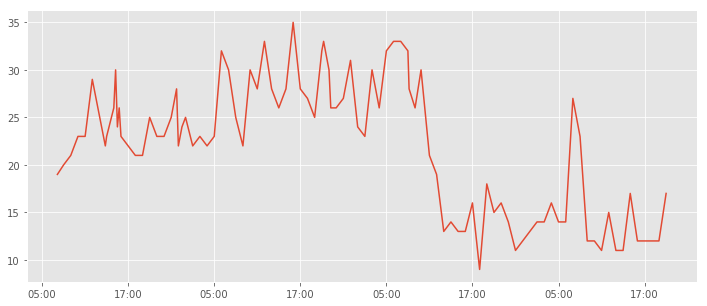

In [46]:
figure(figsize=(12, 5))
tmp = vit_discharged[((vit_discharged.label == 'Respiratory Rate') & (vit_discharged.subject == 11032))]
plot(tmp.charttime, tmp.value)

In [51]:
for v in vitals_list:
    print v, unique(vit_discharged[vit_discharged.label == v].itemid)

Heart Rate [220045    211]
Respiratory Rate [220210    618]
O2 saturation pulseoxymetry [220277]
Non Invasive Blood Pressure mean [220181]
Non Invasive Blood Pressure systolic [220179]
Non Invasive Blood Pressure diastolic [220180]
Inspired O2 Fraction [223835]
PEEP set [220339]
Ventilator Mode [223849]
Tidal Volume (observed) [224685]
PH (Arterial) [223830]
Arterial O2 pressure [220224]
Arterial CO2 Pressure [220235]


In [42]:
subs = unique(vit_discharged.subject)
len(subs)

6777

In [43]:
vit_discharged

,subject,hadm,itemid,label,unit,charttime,value,h_exp
0,36,165660,220045,Heart Rate,bpm,2134-05-12 06:52:00,94.0,0
1,36,165660,220277,O2 saturation pulseoxymetry,%,2134-05-12 06:52:00,91.0,0
2,36,165660,220210,Respiratory Rate,insp/min,2134-05-12 06:52:00,20.0,0
3,36,165660,220179,Non Invasive Blood Pressure systolic,mmHg,2134-05-12 07:00:00,122.0,0
4,36,165660,220277,O2 saturation pulseoxymetry,%,2134-05-12 07:00:00,93.0,0
5,36,165660,220045,Heart Rate,bpm,2134-05-12 07:00:00,92.0,0
6,36,165660,220210,Respiratory Rate,insp/min,2134-05-12 07:00:00,16.0,0
7,36,165660,220180,Non Invasive Blood Pressure diastolic,mmHg,2134-05-12 07:00:00,72.0,0
8,36,165660,220181,Non Invasive Blood Pressure mean,mmHg,2134-05-12 07:00:00,84.0,0
9,36,165660,220277,O2 saturation pulseoxymetry,%,2134-05-12 07:04:00,85.0,0


In [ ]:
fig = plt.figure(figsize=(20, 8))

plot(test.vented)
#plot(test["Inspired O2 Fraction"])
#plot(test["PEEP set"])
#plot(test["O2 saturation pulseoxymetry"])
plot(test["Ventilator Mode"])
#plot(test["Heart Rate"])
plot(test['SBT'].notnull())

In [ ]:
# get rid of times, categorize demographic vars

In [ ]:
#vit_discharged[(vit_discharged.hadm == h) & (vit_discharged.label == 'Height (cm)')].head(1).value.item() | True

In [ ]:
print len(vent_discharged), len(vent_discharged.hadm.unique())

In [ ]:
vent_discharged.icustay.value_counts() #> 1

In [332]:
sed_discharged[sed_discharged.route == "IV DRIP"].formulary_drug_cd.value_counts()

PROP100IG    9177
PROP200IG    5373
MIDA50I      1994
MIDA100      1439
DEXM200I      215
LORA20I        40
MIDA2I          9
MIDA5I          2
MIDA5050        1
Name: formulary_drug_cd, dtype: int64

In [340]:
vit_discharged[(vit_discharged.hadm == 156310) & (vit_discharged.label == 'Admission Weight (Kg)')]

,subject,hadm,icustay,itemid,label,unit,charttime,value,h_exp
6445009,48388,156310,275794.0,226512,Admission Weight (Kg),kg,2157-09-05 09:36:00,89.2,0


In [350]:
vit_discharged[(vit_discharged.hadm == 156310) & (vit_discharged.label == 'Height (cm)')].value.item()

188.0

In [217]:
sbt_discharged.hadm.unique()[0:10]

array([100009, 115545, 170157, 102365, 156708, 104140, 192698, 109444,
       190933, 147191])